## Install libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
import random
import numpy as np

# Set seed
torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.cuda.manual_seed_all(7)
np.random.seed(7)
random.seed(7)

In [3]:
pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


# **Load the dataset: en (English)**

In [4]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

Mounted at /content/drive


In [5]:
import pandas as pd

# Load train and test datasets
train_df = pd.read_csv("train.tsv",  sep='\t', on_bad_lines='skip')
test_df = pd.read_csv("test.tsv",  sep='\t', on_bad_lines='skip')
print('Train dataset size:', train_df.shape)
print('Test dataset size:', test_df.shape)

Train dataset size: (33845, 6)
Test dataset size: (21832, 6)


In [6]:
# Since we will only focus on a binary classification, we do not need the id, prompt and model variables
# We will mantain the domain variable to later study how well the model works depending on the domain
train_df = train_df.drop(['id', 'prompt', 'model'], axis=1)
test_df = test_df.drop(['id', 'prompt', 'model'], axis=1)

## Split the data
We will first split the train and test dataset into X_train, y_train, domains_train and X_test, y_test, domains_test, respectivately.

In [7]:
# Texts
X_train = train_df['text']
X_test = test_df['text']

# Extract labels
y_train = train_df['label']
y_test = test_df['label']

# Extract domain column, we will use it later
domains_train = train_df['domain']
domains_test = test_df['domain']

# Label Encoding
Transform the labels to digit format, i.e., 0 : *human*; 1 : *generated*.

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = y_train.tolist()
y_test = y_test.tolist()

le = LabelEncoder()

print("Before transforming: ", y_train[:10])
y_train = le.fit_transform(y_train)
labels = le.classes_
print("After transforming:", y_train[:10])

print("Before transforming: ", y_test[:10])
y_test = le.transform(y_test)
print("After transforming:", y_test[:10])

label2idx={}
for index, label in enumerate(labels):
    label2idx.update([(label, index)])
print('Labels:', label2idx)

Before transforming:  ['generated', 'generated', 'generated', 'human', 'human', 'generated', 'generated', 'human', 'generated', 'generated']
After transforming: [0 0 0 1 1 0 0 1 0 0]
Before transforming:  ['human', 'human', 'generated', 'human', 'human', 'generated', 'human', 'generated', 'generated', 'human']
After transforming: [1 1 0 1 1 0 1 0 0 1]
Labels: {'generated': 0, 'human': 1}


# CNN (Convolutional Neural Networks)

## Preprocessing

In [9]:
# Tranform data into list
X_train = X_train.tolist()

Represent our texts into tokens using Keras. This way we can build our model with a vector of tokens.

In [10]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = True)
# Train the tokenizer using the texts
tokenizer.fit_on_texts(X_train)

# Use index 0 represents token padding (all texts have same length)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Size of vocabulary = {}".format(NUM_WORDS))

Size of vocabulary = 45686


In [11]:
# Look at some of the words in the dictionary and their corresponding index
for (word,index) in tokenizer.word_index.items():
    print(index,word)
    if index==5:
        break

1 True
2 the
3 to
4 of
5 and


In [12]:
# Transform the tokens into a sequence of integer numbers
encoded_train = tokenizer.texts_to_sequences(X_train)

In [13]:
# Let's view an instance
print(X_train[0])
print(encoded_train[0])

you need to stop the engine and wait until it stops. This is how I would do it: // Check if its safe
[8, 84, 3, 708, 2, 1786, 5, 655, 152, 17, 5271, 9, 11, 91, 22, 166, 60, 17, 291, 23, 30, 774]


We can see from below that the texts have different lengths:

In [14]:
length_train=[len(s) for s in encoded_train]
print(length_train)

[22, 85, 22, 20, 59, 21, 82, 78, 23, 77, 14, 84, 66, 78, 90, 77, 20, 66, 64, 21, 23, 16, 54, 86, 23, 88, 22, 89, 88, 86, 15, 29, 91, 68, 22, 23, 85, 75, 81, 22, 75, 86, 19, 90, 88, 89, 88, 34, 68, 38, 86, 20, 21, 69, 23, 58, 64, 22, 17, 45, 14, 89, 10, 61, 69, 21, 21, 72, 82, 72, 20, 57, 34, 81, 52, 68, 75, 87, 20, 79, 75, 24, 24, 73, 82, 79, 15, 22, 76, 19, 90, 18, 83, 69, 82, 19, 46, 24, 46, 97, 85, 92, 43, 17, 21, 56, 13, 91, 78, 78, 71, 72, 93, 76, 90, 74, 19, 23, 24, 16, 19, 22, 57, 44, 84, 22, 60, 83, 19, 65, 20, 64, 82, 33, 86, 84, 78, 86, 77, 19, 60, 74, 20, 78, 82, 85, 37, 88, 19, 18, 22, 19, 79, 13, 51, 73, 84, 87, 23, 39, 58, 83, 61, 69, 14, 38, 81, 82, 74, 67, 26, 54, 73, 16, 21, 67, 73, 18, 19, 73, 70, 78, 92, 64, 88, 79, 18, 73, 77, 23, 45, 80, 83, 89, 88, 25, 87, 56, 74, 81, 88, 80, 17, 61, 59, 69, 86, 90, 14, 21, 23, 23, 37, 20, 50, 57, 18, 60, 64, 16, 72, 16, 20, 67, 18, 88, 21, 21, 18, 50, 16, 75, 21, 19, 21, 72, 24, 15, 21, 24, 84, 81, 20, 18, 76, 88, 18, 20, 85, 22,

To build our CNN model we need all texts to have the same length.

As we saw in the Text Size Distribution section, the mean length of the texts is 54 tokens while 75% of the texts have 81 or less tokens, and the maximum value is 98 tokens. For this reason, we will establish a optimum text size of 85 tokens.

If a text has less words than the maximum length, we will use padding.
If it has more words, we will use truncation.

In [15]:
from keras.utils import pad_sequences
MAX_LEN=85  # 85 está bien o es muy alto???
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')

In [16]:
print(encoded_train_pad[0])
print(encoded_train[0])
print(X_train[0])

[   8   84    3  708    2 1786    5  655  152   17 5271    9   11   91
   22  166   60   17  291   23   30  774    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
[8, 84, 3, 708, 2, 1786, 5, 655, 152, 17, 5271, 9, 11, 91, 22, 166, 60, 17, 291, 23, 30, 774]
you need to stop the engine and wait until it stops. This is how I would do it: // Check if its safe


## CNN with 3 Layers

### Hyperparameters Tuning

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

param_grid = dict(filter1 = [64, 128],
                  filter2 = [32, 64],
                  filter3 = [16, 32],
                  kernel = [2, 3],
                  learning_rate = [0.001, 0.01],
                  embedding_size = [50, 100, 200, 300])

def cnn_model(filter1, filter2, filter3, kernel, learning_rate, embedding_size):
  model = Sequential()
  model.add(Embedding(NUM_WORDS, embedding_size, input_length=MAX_LEN))

  if kernel == 2:
    model.add(Conv1D(filters=filter1, kernel_size=4, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=filter2, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=filter3, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

  else:
    model.add(Conv1D(filters=filter1, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=filter2, kernel_size=4, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=filter3, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

  model.add(Flatten())  # convert input to dense layer to a one dimensional vector
  model.add(Dense(100, activation='relu')) #50, 100, 256
  # Binary Classification
  model.add(Dense(1, activation='sigmoid'))  # if probability near 1 returns 1, 0 otherwise

  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
  print(model.summary())
  return model

model = KerasClassifier(build_fn=cnn_model,
                          epochs=5, batch_size=32)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='f1_macro',
                          cv=3, verbose=1, n_iter=5)
grid_result = grid.fit(encoded_train_pad, y_train, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')
# Evaluate testing set
test_accuracy = grid.score(encoded_test_pad, y_test)

print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


<ipython-input-19-7fd498529a06>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=cnn_model,


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 300)           13705800  
                                                                 
 conv1d (Conv1D)             (None, 85, 128)           192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 42, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 42, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 21, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 32)            6

In [ ]:
print(test_accuracy)

0.5878068804740906


### Best 3 layered CNN Model
Build model with the best parameters.

In [17]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping

best_model = Sequential()

#### First Layer (Embeddings)

Represent each text as a matrix of vectors, where:
- Ner rows = MAX_LEN (words in a text)
- Ner columns = Ner dimensions

Resulting in a MAX_LEN x EMBEDDING_SIZE matrix.

In [18]:
embedding_size=300
best_model.add(Embedding(NUM_WORDS, embedding_size, input_length=MAX_LEN))

#### Convolutional and Pooling Layers

En cada capa de convolución, debemos indicar el número de filtros (a mayor número de filtros, mayor capacidad de representación, pero también mayor coste computacional), y el tamaño del kernel (tamaño de la ventana que se desplaza por la entrada).
Respecto a la capa de max-pooling, usamos pool-size = 2, que significa que de la salida de la capa convolucional, tomará los dos elementos mayores.

In [19]:
# Since we are working with texts, we will use Conv1D

best_model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))

best_model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))

best_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))

#### Dense Layer

In [20]:
best_model.add(Flatten())  # convert input to dense layer to a one dimensional vector
best_model.add(Dense(100, activation='relu')) #50, 100, 128, 256
# Binary Classification
best_model.add(Dense(1, activation='sigmoid'))  # if probability near 1 returns 1, 0 otherwise

#### Compile the model

In [21]:
best_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 300)           13705800  
                                                                 
 conv1d (Conv1D)             (None, 85, 128)           192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 42, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 42, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 21, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 32)            6

### Train the model

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [23]:
import time
epochs = 5  # ner cycles through the whole dataset
batch_size = 32  #16, 32 ner of samples for each step, each epoch has 33845/32 ~ 1058 steps

start_time = time.time()

# training
history=best_model.fit(encoded_train_pad,  # preprocessed texts
                  y_train,            # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

end_time = time.time()
print('Execution time: ', time.strftime("%Hh %Mm %Ss", time.gmtime(end_time-start_time)))

Epoch 1/5
847/847 [==============================] - 62s 59ms/step - loss: 0.4644 - accuracy: 0.7600 - val_loss: 0.3962 - val_accuracy: 0.8124
Epoch 2/5
847/847 [==============================] - 17s 20ms/step - loss: 0.2444 - accuracy: 0.8971 - val_loss: 0.4279 - val_accuracy: 0.8102
Epoch 3/5
847/847 [==============================] - 14s 16ms/step - loss: 0.0902 - accuracy: 0.9660 - val_loss: 0.6105 - val_accuracy: 0.8041
Execution time:  00h 01m 33s


The training stops at epoch 3.

#### Save trained 3-layered CNN model

In [24]:
best_model.save("3_layered_CNN", include_optimizer=True)

#### Learning Curves

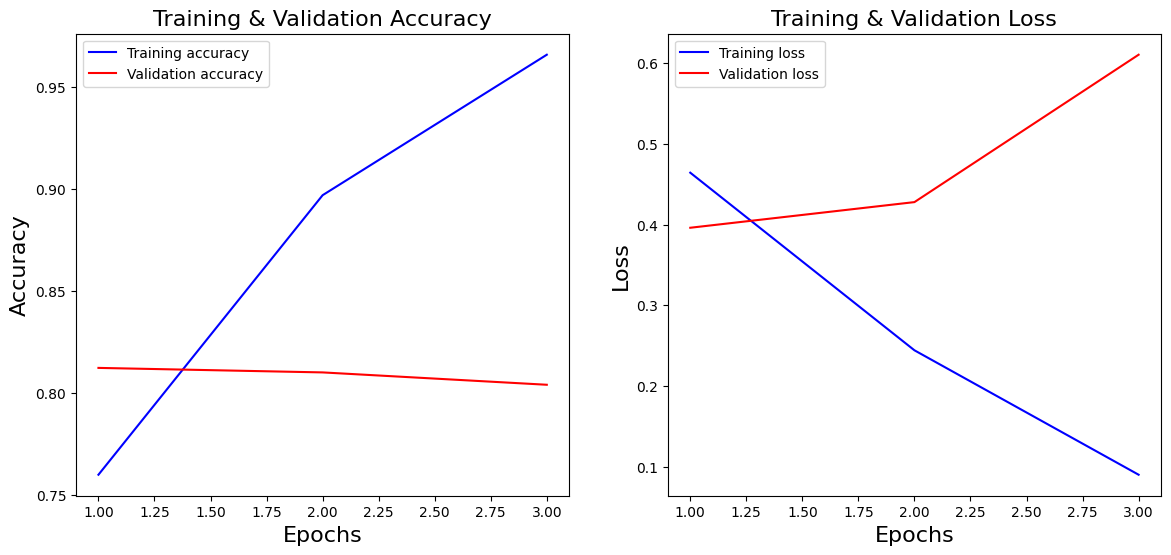

In [25]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Accuracy vs Epochs Curve
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Loss vs Epochs Curve
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

We observe that even though we obtain a training loss near to 0 throughout the execution of epochs, the validation loss increases.

For this reason, we need to improve and obtain a more complex model.

### Evaluate the model

In [26]:
X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

from sklearn.metrics import accuracy_score, classification_report

# Predict with test dataset
y_pred = np.round(best_model.predict(encoded_test_pad))

print('accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labels))

683/683 [==============================] - 2s 2ms/step
accuracy: 0.6211982411139612
              precision    recall  f1-score   support

   generated       0.59      0.89      0.71     11190
       human       0.74      0.34      0.47     10642

    accuracy                           0.62     21832
   macro avg       0.67      0.61      0.59     21832
weighted avg       0.66      0.62      0.59     21832



We obtain a low accuracy of 62%.

Also, the F1-score for the generated texts is 0.7, while for the human texts is 0.50.

Overall, the macro F1-score is 0.60.

[[9952 1238]
 [7032 3610]]


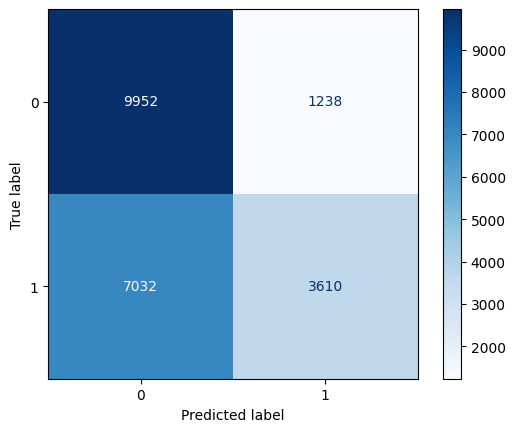

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

We observe that the model classifies correctly 9478 out of 11190 of the generated texts. While out of the total (10642) human texts, it classifies correctly 4119. While the remaining 6523 human texts are classified as generated, meaning our model is not the best.

Compared to the SVM and Naive Bayes algorithms, we get a better model for the human texts, but still we need to improve this score.

#### Evaluation for each Domain in Test dataset

We will evaluate the performance of the SVM model for each of the domains *news* and *reviews*.


In [ ]:
# Calculate predictions and metrics for news domain
X_test_news = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'news']
encoded_test_news = tokenizer.texts_to_sequences(X_test_news)
encoded_test_pad_news = pad_sequences(encoded_test_news, maxlen = MAX_LEN, padding='post')
y_test_news = y_test[domains_test=='news']
y_pred_news = np.round(best_model.predict(encoded_test_pad_news))
print('accuracy:', accuracy_score(y_test_news, y_pred_news))
print("Classification Report for News:")
print(classification_report(y_test_news, y_pred_news, target_names=labels))

# Calculate predictions and metrics for reviews domain
X_test_reviews = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'reviews']
encoded_test_reviews = tokenizer.texts_to_sequences(X_test_reviews)
encoded_test_pad_reviews = pad_sequences(encoded_test_reviews, maxlen = MAX_LEN, padding='post')
y_test_reviews = y_test[domains_test=='reviews']
y_pred_reviews = np.round(best_model.predict(encoded_test_pad_reviews))
print('accuracy:', accuracy_score(y_test_reviews, y_pred_reviews))
print("Classification Report for reviews:")
print(classification_report(y_test_reviews, y_pred_reviews, target_names=labels))

# Combine the confusion matrices plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp_news = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_news, y_pred_news))
disp_news.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix for News')

disp_reviews = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_reviews, y_pred_reviews))
disp_reviews.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('Confusion Matrix for Reviews')

plt.tight_layout()
plt.show()

We observe that the model categorizes incorrectly more than half of the texts written by a human in the news domain.

Moreover, the macro F1s-score is 0.56.

For the texts written by a human in the reviews texts, we see that it does slightly better but still gives many false negatives.

Moreover, the  macro F1s-score is 0.64.

## CNN with 6 Layers (more complex model)

### Hyperparameters Tuning

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

param_grid = dict(filter1 = [128, 256],
                  filter2 = [64, 128],
                  filter3 = [32, 64],
                  filter4 = [16, 32],
                  filter5 = [8, 16],
                  filter6 = [4, 8],
                  learning_rate = [0.001, 0.01],
                  embedding_size = [50, 100, 200, 300])

def cnn_model(filter1, filter2, filter3, filter4, filter5, filter6, learning_rate, embedding_size):
  model = Sequential()
  model.add(Embedding(NUM_WORDS, embedding_size, input_length=MAX_LEN))

  model.add(Conv1D(filters=filter1, kernel_size=7, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=filter2, kernel_size=6, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=filter3, kernel_size=5, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=filter4, kernel_size=4, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=filter5, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=filter6, kernel_size=2, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Flatten())  # convert input to dense layer to a one dimensional vector
  model.add(Dense(100, activation='relu')) #50, 100, 256
  # Binary Classification
  model.add(Dense(1, activation='sigmoid'))  # if probability near 1 returns 1, 0 otherwise

  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
  print(model.summary())
  return model

model = KerasClassifier(build_fn=cnn_model,
                          epochs=5, batch_size=32)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='f1_macro',
                          cv=3, verbose=1, n_iter=5)
grid_result = grid.fit(encoded_train_pad, y_train, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')
# Evaluate testing set
test_accuracy = grid.score(encoded_test_pad, y_test)

print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


<ipython-input-19-fd7356bb6d38>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=cnn_model,


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 300)           13705800  
                                                                 
 conv1d (Conv1D)             (None, 85, 128)           268928    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 42, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 42, 64)            49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 21, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 32)            1

In [ ]:
print(test_accuracy)

0.6044338345527649


### Best 6 layered CNN Model
Build model with the best parameters.

In [28]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping

best_model = Sequential()

#### First Layer (Embeddings)

Represent each text as a matrix of vectors, where:
- Ner rows = MAX_LEN (words in a text)
- Ner columns = Ner dimensions

Resulting in a MAX_LEN x EMBEDDING_SIZE matrix.

In [29]:
embedding_size=300
best_model.add(Embedding(NUM_WORDS, embedding_size, input_length=MAX_LEN))

#### Convolutional and Pooling Layers

En cada capa de convolución, debemos indicar el número de filtros (a mayor número de filtros, mayor capacidad de representación, pero también mayor coste computacional), y el tamaño del kernel (tamaño de la ventana que se desplaza por la entrada).
Respecto a la capa de max-pooling, usamos pool-size = 2, que significa que de la salida de la capa convolucional, tomará los dos elementos mayores.

In [30]:
# Since we are working with texts, we will use Conv1D

best_model.add(Conv1D(filters=64, kernel_size=128, padding='same', activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))

best_model.add(Conv1D(filters=32, kernel_size=128, padding='same', activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))

best_model.add(Conv1D(filters=16, kernel_size=32, padding='same', activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))

best_model.add(Conv1D(filters=8, kernel_size=32, padding='same', activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))

best_model.add(Conv1D(filters=4, kernel_size=8, padding='same', activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))

best_model.add(Conv1D(filters=4, kernel_size=4, padding='same', activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))

#### Dense Layer

In [31]:
best_model.add(Flatten())  # convert input to dense layer to a one dimensional vector
best_model.add(Dense(100, activation='relu')) #50, 100, 128, 256
# Binary Classification
best_model.add(Dense(1, activation='sigmoid'))  # if probability near 1 returns 1, 0 otherwise

#### Compile the model

In [32]:
best_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 85, 300)           13705800  
                                                                 
 conv1d_3 (Conv1D)           (None, 85, 64)            2457664   
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 42, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 42, 32)            262176    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 21, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 16)           

### Train the model

In [33]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [34]:
import time

epochs = 5  # ner cycles through the whole dataset
batch_size = 32  #16, 32 ner of samples for each step, each epoch has 33845/32 ~ 1058 steps

start_time = time.time()

# training
history=best_model.fit(encoded_train_pad,  # preprocessed texts
                  y_train,            # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

end_time = time.time()
print('Execution time: ', time.strftime("%Hh %Mm %Ss", time.gmtime(end_time-start_time)))

Epoch 1/5
847/847 [==============================] - 42s 45ms/step - loss: 0.4961 - accuracy: 0.7351 - val_loss: 0.3979 - val_accuracy: 0.8047
Epoch 2/5
847/847 [==============================] - 16s 19ms/step - loss: 0.2755 - accuracy: 0.8805 - val_loss: 0.4076 - val_accuracy: 0.8158
Epoch 3/5
847/847 [==============================] - 14s 16ms/step - loss: 0.1285 - accuracy: 0.9473 - val_loss: 0.5670 - val_accuracy: 0.8012
Execution time:  00h 01m 12s


The training stops at epoch 3.

#### Save trained 6-layered CNN model

In [35]:
best_model.save("6_layered_CNN", include_optimizer=True)

#### Learning Curves

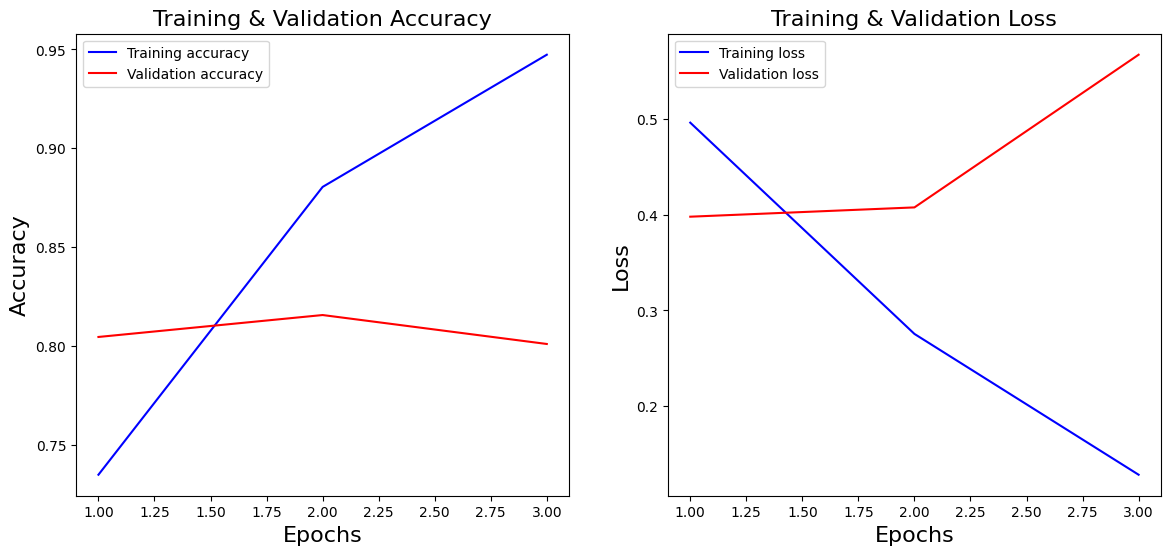

In [36]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Accuracy vs Epochs Curve
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Loss vs Epochs Curve
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

We obtain similar learning curves.

### Evaluate the model

In [37]:
#X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

from sklearn.metrics import accuracy_score, classification_report

# Predict with test dataset
y_pred = np.round(best_model.predict(encoded_test_pad))

print('accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labels))

683/683 [==============================] - 2s 3ms/step
accuracy: 0.6080524001465738
              precision    recall  f1-score   support

   generated       0.58      0.90      0.70     11190
       human       0.74      0.31      0.43     10642

    accuracy                           0.61     21832
   macro avg       0.66      0.60      0.57     21832
weighted avg       0.65      0.61      0.57     21832



We observe that the results obtained are slightly worse than the the 3-layered CNN ones. This could be due to having a small dataset since having a more complex model did not solve the problem.

Hence, we will remain with the 3-layered CNN.

[[10018  1172]
 [ 7385  3257]]


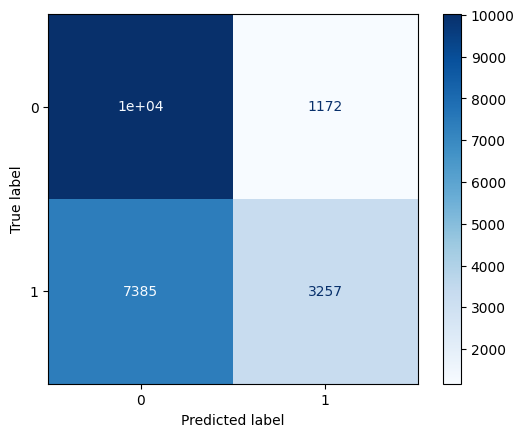

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

We observe that the model classifies correctly 9437 out of 11190 of the generated texts. While out of the total (10642) human texts, it classifies correctly 4073. While the remaining 6569 human texts are classified as generated, meaning our model is not the best.

Compared to the 3-layered CNN we get worse f1-scores.

#### Evaluation for each Domain in Test dataset

We will evaluate the performance of the CNN model for each of the domains *news* and *reviews*.


342/342 [==============================] - 1s 3ms/step
accuracy: 0.5603953147877013
              precision    recall  f1-score   support

   generated       0.54      0.81      0.65      5464
       human       0.62      0.31      0.42      5464

    accuracy                           0.56     10928
   macro avg       0.58      0.56      0.53     10928
weighted avg       0.58      0.56      0.53     10928

[[4408 1056]
 [3748 1716]]


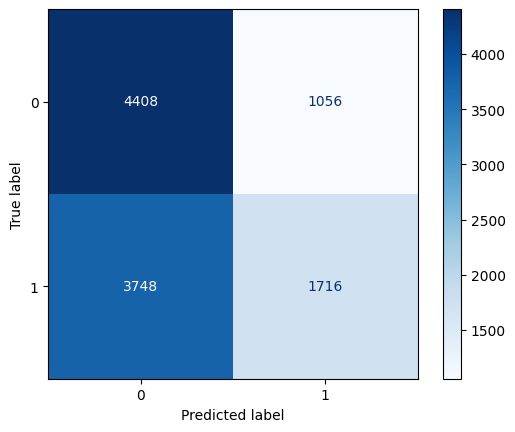

In [ ]:
X_test_news = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'news']
encoded_test_news = tokenizer.texts_to_sequences(X_test_news)
encoded_test_pad_news = pad_sequences(encoded_test_news, maxlen = MAX_LEN, padding='post')
y_test_news = y_test[domains_test=='news']

# Predict with test dataset with domain 'news'
y_pred_news = np.round(best_model.predict(encoded_test_pad_news))
print('accuracy:', accuracy_score(y_test_news, y_pred_news))
print(classification_report(y_test_news, y_pred_news, target_names=labels))
print(confusion_matrix(y_test_news, y_pred_news))
disp=ConfusionMatrixDisplay.from_predictions(y_test_news, y_pred_news, cmap=plt.cm.Blues)

We observe that the model categorizes incorrectly less than half of the texts written by a human in the news domain.

Moreover, the macro F1s-score is 0.53.

341/341 [==============================] - 1s 4ms/step
accuracy: 0.6773661041819515
              precision    recall  f1-score   support

   generated       0.64      0.88      0.74      5726
       human       0.77      0.46      0.57      5178

    accuracy                           0.68     10904
   macro avg       0.71      0.67      0.66     10904
weighted avg       0.70      0.68      0.66     10904

[[5029  697]
 [2821 2357]]


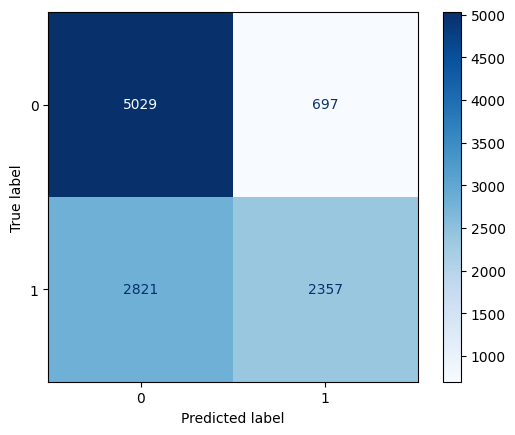

In [ ]:
X_test_reviews = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'reviews']
encoded_test_reviews = tokenizer.texts_to_sequences(X_test_reviews)
encoded_test_pad_reviews = pad_sequences(encoded_test_reviews, maxlen = MAX_LEN, padding='post')
y_test_reviews = y_test[domains_test=='reviews']

# Predict with test dataset with domain 'reviews'
y_pred_reviews = np.round(best_model.predict(encoded_test_pad_reviews))
print('accuracy:', accuracy_score(y_test_reviews, y_pred_reviews))
print(classification_report(y_test_reviews, y_pred_reviews, target_names=labels))
print(confusion_matrix(y_test_reviews, y_pred_reviews))
disp=ConfusionMatrixDisplay.from_predictions(y_test_reviews, y_pred_reviews, cmap=plt.cm.Blues)

For the texts written by a human in the reviews texts, we see that it does slightly better than the news domain but still gives many false negatives.

Moreover, it is the best f1-score we have obtained for any domain including the results of the 3-layered CNN.

Moreover, the  macro F1s-score is 0.66.

### Function clean_text()
We will use the function clean_text() additionally and see how the CNN model performs.

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stopwords_en = stopwords.words("english")

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re

def clean_text(text):
    # transform to lower case
    text=str(text).lower()
    # tokenize
    tokens=word_tokenize(text)
    # eliminate stopwords
    tokens = [word for word in tokens if word not in stopwords_en]
    # apply stemming
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminate words with length lower than 3
    min_length = 3
    # ignore words that contain a digit or a special symbol
    p = re.compile('^[a-zA-Z]+$');

    # stored clean tokens
    filtered_tokens=[]
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens.append(token)

    return filtered_tokens

In [ ]:
clean_X_train = [' '.join(clean_text(sentence)) for sentence in X_train]
clean_X_train

['need stop engin wait stop would check safe',
 'commiss shall publish report interim report least everi two year whenev consid report necessari appropri commiss may request relev inform member state council european parliament intern organ bodi special agenc commiss shall ensur adequ access compet nation author purpos implement regul commiss shall give special attent social dimens programm',
 'tweet lot late novemb realli good month also',
 'pass exam realli thankgod idk shsmi result',
 'templat part mustach shape bow tie shape skinni rectangl mustach shape eventu make bow loop bow tie shape actual make bow tail glue bow scrapbook project secur glue dot instead also use doublesid tape foam mount tape',
 'jonasbroth guy rock love song thank love love hear music bring',
 'paragraph amend follow case derog vehicl one altern subject restrict may use instead altern compli applic requir paragraph purpos articl annex recommend conform least one follow meet relev criteria set annex regul',
 '

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer_clean = Tokenizer(oov_token = True)
# Train the tokenizer using the texts
tokenizer_clean.fit_on_texts(clean_X_train)

# use index 0 represents token padding (all texts have same length)
tokenizer_clean.word_index['<PAD>'] = 0

NUM_WORDS_CLEAN=len(tokenizer_clean.word_index)
print("Size of vocabulary = {}".format(NUM_WORDS_CLEAN))

Size of vocabulary = 27196


In [ ]:
for (word,index) in tokenizer_clean.word_index.items():
    print(index,word)
    if index==5:
        break

1 True
2 shall
3 articl
4 regul
5 use


In [ ]:
# Transform the tokens into a sequence of integer numbers
encoded_train_clean = tokenizer_clean.texts_to_sequences(clean_X_train)

# Let's view an instance
print(clean_X_train[0])
print(encoded_train_clean[0])

need stop engin wait stop would check safe
[26, 495, 938, 395, 495, 92, 163, 592]


[8, 49, 8, 7, 37, 11, 32, 40, 11, 46, 7, 30, 27, 40, 41, 41, 8, 36, 41, 9, 10, 7, 30, 39, 9, 43, 10, 36, 42, 45, 6, 12, 50, 33, 11, 11, 39, 33, 48, 10, 34, 41, 7, 39, 38, 41, 34, 16, 31, 17, 42, 10, 13, 35, 12, 28, 30, 6, 7, 25, 8, 45, 5, 35, 30, 11, 12, 26, 40, 41, 8, 25, 16, 40, 27, 34, 33, 47, 10, 43, 38, 11, 10, 25, 39, 38, 7, 10, 46, 11, 41, 5, 47, 34, 41, 8, 25, 11, 23, 42, 45, 40, 18, 9, 12, 27, 9, 48, 32, 41, 42, 40, 46, 43, 46, 38, 11, 8, 14, 9, 9, 11, 31, 18, 42, 11, 36, 41, 8, 30, 12, 25, 40, 12, 47, 42, 40, 44, 49, 6, 32, 36, 12, 43, 37, 42, 21, 47, 8, 9, 8, 10, 41, 6, 27, 38, 42, 55, 9, 17, 29, 40, 29, 38, 6, 18, 44, 38, 38, 29, 8, 24, 35, 6, 9, 47, 40, 7, 10, 26, 31, 39, 48, 32, 40, 34, 5, 50, 36, 9, 21, 33, 29, 40, 41, 16, 39, 27, 39, 49, 51, 37, 7, 35, 33, 37, 42, 44, 4, 11, 11, 11, 14, 11, 20, 30, 8, 28, 30, 10, 37, 8, 14, 36, 7, 43, 10, 9, 12, 27, 7, 44, 4, 11, 8, 38, 10, 4, 12, 8, 36, 31, 8, 10, 45, 40, 7, 6, 46, 11, 38, 8, 38, 40, 10, 22, 13, 39, 39, 11, 12, 40, 47,

<Axes: >

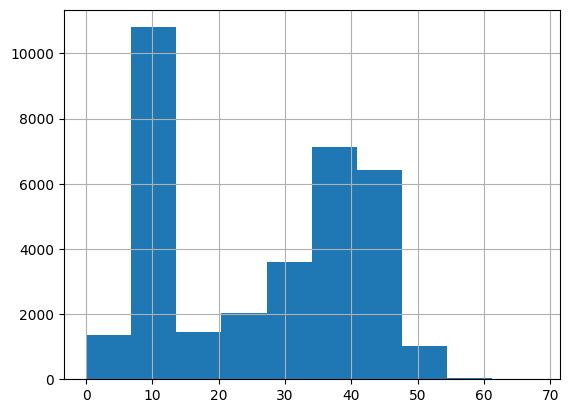

In [ ]:
length_train_clean=[len(s) for s in encoded_train_clean]
print(length_train_clean)

df_lengths_clean = pd.Series(length_train_clean)
# cleaned text distribution
df_lengths_clean.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])
df_lengths_clean.hist()

In [ ]:
from keras.utils import pad_sequences
MAX_LEN_CLEAN=45
encoded_train_pad_clean = pad_sequences(encoded_train_clean, maxlen = MAX_LEN_CLEAN,
                              padding='post', truncating='post')

print(encoded_train_pad_clean[0])
print(encoded_train_clean[0])
print(clean_X_train[0])

[ 26 495 938 395 495  92 163 592   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
[26, 495, 938, 395, 495, 92, 163, 592]
need stop engin wait stop would check safe


In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

model_clean = Sequential()

EMBEDDING_SIZE=300 #try with 100, 200, 300
model_clean.add(Embedding(NUM_WORDS_CLEAN, EMBEDDING_SIZE, input_length=MAX_LEN_CLEAN))

model_clean.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model_clean.add(MaxPooling1D(pool_size=2))

model_clean.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model_clean.add(MaxPooling1D(pool_size=2))

model_clean.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_clean.add(MaxPooling1D(pool_size=2))


model_clean.add(Flatten())
model_clean.add(Dense(50, activation='relu'))
# Binary Classification
model_clean.add(Dense(1, activation='sigmoid'))  # if probability near 1 returns 1, 0 otherwise

model_clean.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_clean.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 300)           8158800   
                                                                 
 conv1d (Conv1D)             (None, 45, 128)           192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 32)            6

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 3 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

epochs = 5
batch_size = 32

# training
history_clean=model_clean.fit(encoded_train_pad_clean,  # preprocessed texts
                  y_train,                              # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

Epoch 1/5
847/847 [==============================] - 46s 50ms/step - loss: 0.5135 - accuracy: 0.7196 - val_loss: 0.4634 - val_accuracy: 0.7616
Epoch 2/5
847/847 [==============================] - 16s 19ms/step - loss: 0.3441 - accuracy: 0.8433 - val_loss: 0.4764 - val_accuracy: 0.7706
Epoch 3/5
847/847 [==============================] - 10s 11ms/step - loss: 0.1771 - accuracy: 0.9268 - val_loss: 0.6422 - val_accuracy: 0.7460
Epoch 4/5
847/847 [==============================] - 8s 10ms/step - loss: 0.0695 - accuracy: 0.9741 - val_loss: 0.9139 - val_accuracy: 0.7370


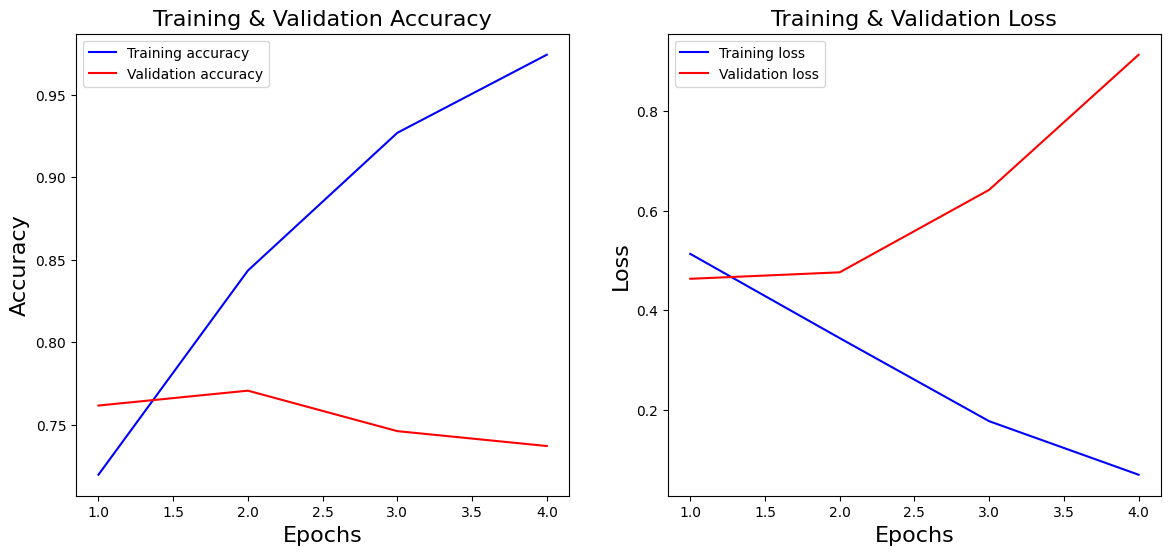

In [ ]:
import matplotlib.pyplot as plt

history_dict_clean = history_clean.history
loss_values_clean = history_dict_clean['loss']
val_loss_values_clean = history_dict_clean['val_loss']
accuracy_clean = history_dict_clean['accuracy']
val_accuracy_clean = history_dict_clean['val_accuracy']

epochs_clean = range(1, len(loss_values_clean) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Accuracy vs Epochs Curve
#
ax[0].plot(epochs_clean, accuracy_clean, 'b', label='Training accuracy')
ax[0].plot(epochs_clean, val_accuracy_clean, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Loss vs Epochs Curve
#
ax[1].plot(epochs_clean, loss_values_clean, 'b', label='Training loss')
ax[1].plot(epochs_clean, val_loss_values_clean, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

683/683 [==============================] - 2s 2ms/step
accuracy: 0.501557347013558
              precision    recall  f1-score   support

   generated       0.55      0.16      0.24     11190
       human       0.49      0.86      0.63     10642

    accuracy                           0.50     21832
   macro avg       0.52      0.51      0.44     21832
weighted avg       0.52      0.50      0.43     21832

[[1745 9445]
 [1437 9205]]


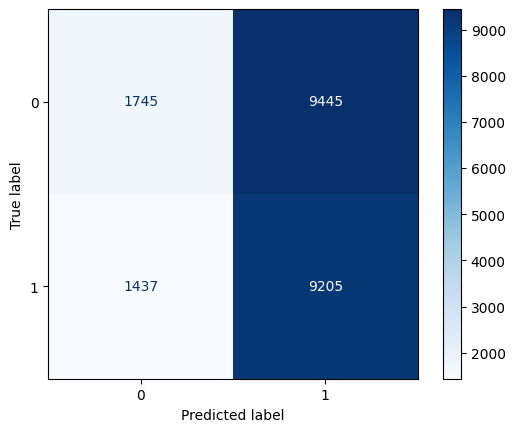

In [ ]:
#X_test = X_test.tolist()
encoded_test_clean = tokenizer_clean.texts_to_sequences(X_test)
encoded_test_clean = pad_sequences(encoded_test_clean, maxlen = MAX_LEN_CLEAN, padding='post')

from sklearn.metrics import accuracy_score, classification_report

# Predict with test dataset
y_pred_clean = np.round(model_clean.predict(encoded_test_clean))

print('accuracy:', accuracy_score(y_test, y_pred_clean))
print(classification_report(y_test, y_pred_clean, target_names=labels))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred_clean))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred_clean, cmap=plt.cm.Blues)

We obtain that the model does very good with the human texts, while most of the generated ones are false positives.

Overall, we get a macro F1-score of 0.44.

#### Evaluation for each Domain in Test dataset

We will evaluate the performance of the SVM model for each of the domains *news* and *reviews*.

342/342 [==============================] - 1s 3ms/step
accuracy: 0.508601756954612
              precision    recall  f1-score   support

   generated       0.51      0.55      0.53      5464
       human       0.51      0.47      0.49      5464

    accuracy                           0.51     10928
   macro avg       0.51      0.51      0.51     10928
weighted avg       0.51      0.51      0.51     10928

[[2991 2473]
 [2897 2567]]


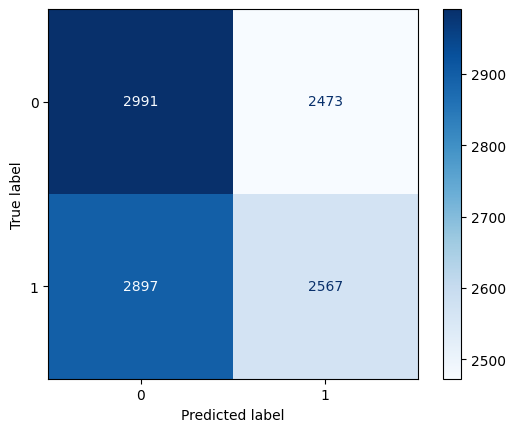

In [ ]:
X_test_news = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'news']
encoded_test_news = tokenizer.texts_to_sequences(X_test_news)
encoded_test_pad_news = pad_sequences(encoded_test_news, maxlen = MAX_LEN_CLEAN, padding='post')
y_test_news = y_test[domains_test=='news']

# Predict with test dataset with domain 'news'
y_pred_news = np.round(model_clean.predict(encoded_test_pad_news))
print('accuracy:', accuracy_score(y_test_news, y_pred_news))
print(classification_report(y_test_news, y_pred_news, target_names=labels))
print(confusion_matrix(y_test_news, y_pred_news))
disp=ConfusionMatrixDisplay.from_predictions(y_test_news, y_pred_news, cmap=plt.cm.Blues)

We observe that the model categorizes incorrectly around half of the texts written by a human in the news domain.

Moreover, the macro F1s-score is 0.51.

341/341 [==============================] - 1s 3ms/step
accuracy: 0.4987160674981658
              precision    recall  f1-score   support

   generated       0.52      0.60      0.55      5726
       human       0.47      0.39      0.43      5178

    accuracy                           0.50     10904
   macro avg       0.49      0.49      0.49     10904
weighted avg       0.49      0.50      0.49     10904

[[3408 2318]
 [3148 2030]]


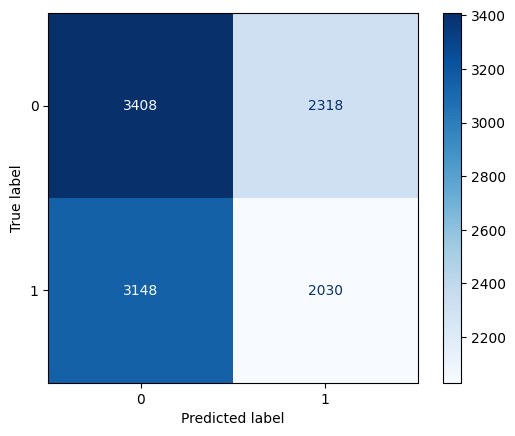

In [ ]:
X_test_reviews = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'reviews']
encoded_test_reviews = tokenizer.texts_to_sequences(X_test_reviews)
encoded_test_pad_reviews = pad_sequences(encoded_test_reviews, maxlen = MAX_LEN_CLEAN, padding='post')
y_test_reviews = y_test[domains_test=='reviews']

# Predict with test dataset with domain 'reviews'
y_pred_reviews = np.round(model_clean.predict(encoded_test_pad_reviews))
print('accuracy:', accuracy_score(y_test_reviews, y_pred_reviews))
print(classification_report(y_test_reviews, y_pred_reviews, target_names=labels))
print(confusion_matrix(y_test_reviews, y_pred_reviews))
disp=ConfusionMatrixDisplay.from_predictions(y_test_reviews, y_pred_reviews, cmap=plt.cm.Blues)

We observe that the model classifies most of the generated texts correctly (3408 out of 5726). However, out of the total (5178) human texts, it only classifies correctly 2030. While the remaining 3148 human texts are classified as generated, meaning our model is not the best.

Moreover, the macro F1-score is 0.49.

Overall, we can say that using the clean_text() function for preprocessing our datasets, performs worse than not using it. This is because the Keras classifier does not need the data to be cleaned before training the model.